In [1]:
#| default_exp fid

# FID

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [3]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Classifier

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [5]:
b = xb,yb = next(iter(dls.train))

In [6]:
cbs = [DeviceCB(), MixedPrecision()]
model = torch.load('models/data_aug2.pkl', weights_only=False)
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)

In [7]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook,'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [8]:
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

In [9]:
learn.fit(1, train=False, cbs=[hcb])

/workspace/ml_env/miniai/accel.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


In [10]:
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

In [11]:
del(learn.model[8])
del(learn.model[7])

In [12]:
feats,y = learn.capture_preds()
feats = feats.float()
feats.shape,y

(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

## Calc FID

In [13]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [14]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [15]:
dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [16]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [17]:
smodel = torch.load('models/fashion_ddpm_mp.pkl', weights_only=False).cuda()

In [18]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_0_hat.cpu())
    return preds

In [19]:
%%time
samples = sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 44.9 s, sys: 824 ms, total: 45.7 s
Wall time: 44.6 s


In [20]:
len(samples), samples[0].shape

(1000, torch.Size([256, 1, 32, 32]))

In [21]:
s = samples[-1]*2-1

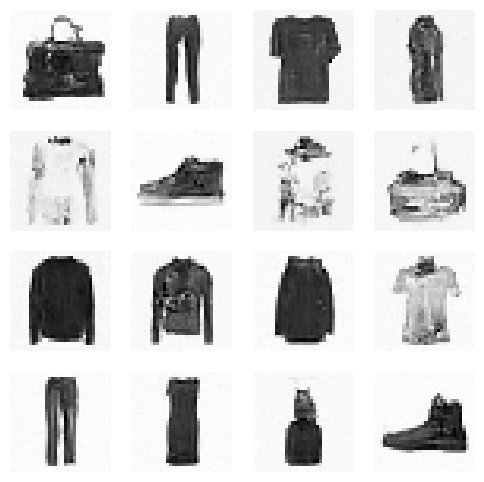

In [22]:
show_images(s[:16], imsize=1.5)

In [23]:
clearn = TrainLearner(model, DataLoaders([],[(s,yb)]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2,y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([256, 512])

In [24]:
means = feats.mean(0)
means.shape

torch.Size([512])

In [25]:
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [26]:
#|export
def _sqrtm_newton_schulz(mat, num_iters=100):
    mat_nrm = mat.norm()
    mat = mat.double()
    Y = mat/mat_nrm
    n = len(mat)
    I = torch.eye(n, n).to(mat)
    Z = torch.eye(n, n).to(mat)

    for i in range(num_iters):
        T = (3*I - Z@Y)/2
        Y,Z = Y@T,T@Z
        res = Y*mat_nrm.sqrt()
        if ((mat-(res@res)).norm()/mat_nrm).abs()<=1e-6: break
    return res

In [27]:
#|export
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
#     csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [28]:
s1,s2 = _calc_stats(feats),_calc_stats(feats2)

In [29]:
_calc_fid(*s1, *s2)

/tmp/ipykernel_3977/3009118759.py:8: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  csr = tensor(linalg.sqrtm(c1@c2, 256).real)


41.078857421875

In [30]:
#|export
def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - kxy_sum*2/m/n

In [31]:
#|export
def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [32]:
_calc_kid(feats, feats2)

0.17651931941509247

## FID class

In [33]:
#|export
class ImageEval:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)

    def get_feats(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        return self.learn.capture_preds()[0].float().cpu().squeeze()

    def fid(self, samp): return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))
    def kid(self, samp): return _calc_kid(self.feats, self.get_feats(samp))

In [34]:
ie = ImageEval(model, learn.dls, cbs=[DeviceCB()])

In [35]:
%%time
ie.fid(s)

CPU times: user 8.15 s, sys: 701 ms, total: 8.85 s
Wall time: 820 ms


/tmp/ipykernel_3977/3009118759.py:8: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  csr = tensor(linalg.sqrtm(c1@c2, 256).real)


41.005615234375

In [36]:
%%time
ie.kid(s)

CPU times: user 2 s, sys: 144 ms, total: 2.15 s
Wall time: 167 ms


0.17623424530029297

/tmp/ipykernel_3977/3009118759.py:8: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  csr = tensor(linalg.sqrtm(c1@c2, 256).real)


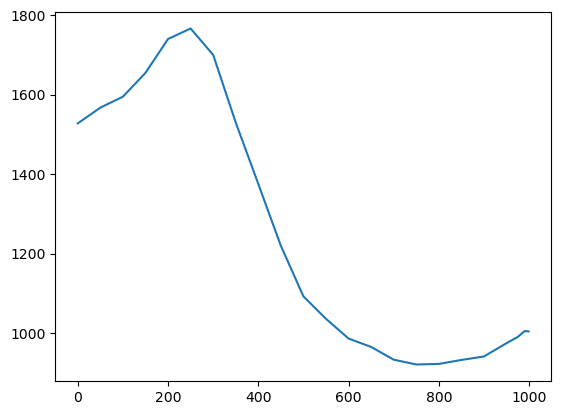

In [37]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.fid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

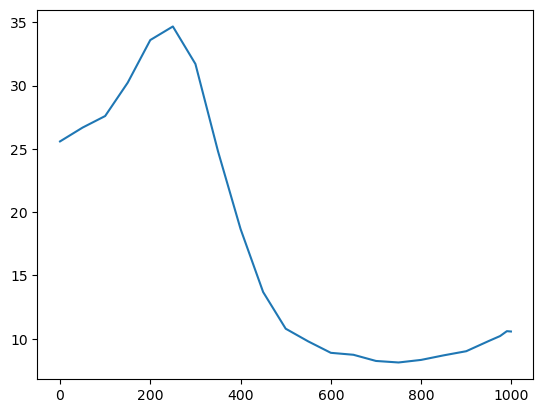

In [38]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.kid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

In [39]:
ie.fid(xb)

/tmp/ipykernel_3977/3009118759.py:8: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  csr = tensor(linalg.sqrtm(c1@c2, 256).real)


6.221923828125

In [40]:
ie.kid(xb)

-0.012506181374192238

## Inception

In [41]:
from pytorch_fid.inception import InceptionV3

In [42]:
a = tensor([1,2,3])
a.repeat((3,1))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [43]:
class IncepWrap(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = InceptionV3(resize_input=True)
    def forward(self, x): return self.m(x.repeat(1,3,1,1))[0]

In [59]:
bs = 128 # Got OOMs with 512 and 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [53]:
ie = ImageEval(IncepWrap(), dls, cbs=[DeviceCB()])

In [54]:
%%time
ie.fid(s)

CPU times: user 2min 50s, sys: 14.7 s, total: 3min 5s
Wall time: 21.9 s


/tmp/ipykernel_3977/3009118759.py:8: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  csr = tensor(linalg.sqrtm(c1@c2, 256).real)


59.288604736328125

In [55]:
ie.fid(xb)

/tmp/ipykernel_3977/3009118759.py:8: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  csr = tensor(linalg.sqrtm(c1@c2, 256).real)


27.573211669921875

In [56]:
%%time
ie.kid(s)

CPU times: user 6.14 s, sys: 390 ms, total: 6.53 s
Wall time: 783 ms


0.007896065711975098

In [57]:
ie.kid(xb)

9.981068433262408e-05

## Export -

In [58]:
import nbdev; nbdev.nbdev_export()

/venv/ml/lib/python3.12/site-packages/nbdev/doclinks.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources,importlib
